# Load data

In [1]:

import numpy as np
import pandas as pd

import features.config as config
import features.modelling as ml

In [2]:
# Load taxi and weather data
taxi_weather_raw = pd.read_csv(config.TAXI_WEATHER_DATA_SAVE)

## split train and test set

In [3]:
train_set, test_set = ml.split_train_test(taxi_weather_raw, config.TEST_SIZE,
                                          config.RANDOM_STATE)

# KMeans-Clusterer

In [4]:
taxi_weather = train_set.copy()
taxi_weather.drop(['trip_duration', 'trip_duration_log', 'trip_duration_min'], axis=1, inplace=True)
taxi_weather_labels = train_set[['trip_duration', 'trip_duration_log', 'trip_duration_min']].copy()

## pickup cluster

In [5]:
coords = taxi_weather[['pickup_longitude', 'pickup_latitude']]

In [6]:
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt
#
# inertias = []
# K = range(2, 16)  # von 2 bis 20 Cluster testen
#
# for k in K:
#   kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
#   kmeans.fit(coords)
#   inertias.append(kmeans.inertia_)
#
# plt.figure(figsize=(8, 4))
# plt.plot(K, inertias, 'o-')
# plt.xlabel("Number of clusters (k)")
# plt.ylabel("Inertia (Measure of inertia)")
# plt.title("Elbow method: KMeans on GPS coordinates")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [7]:
import folium
from sklearn.cluster import MiniBatchKMeans
import matplotlib.cm as cm

kmeans = MiniBatchKMeans(n_clusters=5, random_state=42, batch_size=10000)
pickup_labels = kmeans.fit_predict(coords)
taxi_weather['pickup_cluster'] = pickup_labels
centers = kmeans.cluster_centers_

# Interaktive Karte
m_pickup = folium.Map(location=[40.75, -73.97], zoom_start=11)

colors = cm.tab10.colors  # bis zu 10 unterschiedliche Farben
sample = taxi_weather.sample(1000, random_state=42)

for _, row in sample.iterrows():
  cluster = int(row['pickup_cluster'])
  folium.CircleMarker(
      location=[row['pickup_latitude'], row['pickup_longitude']],
      radius=3,
      color=colors[cluster % len(colors)],
      fill=True,
      fill_opacity=0.6,
      weight=0.5
  ).add_to(m_pickup)

# Clusterzentren markieren
for c in centers:
  folium.Marker(location=[c[1], c[0]], icon=folium.Icon(color='black')).add_to(m_pickup)

m_pickup  # zeigt Karte im Notebook

In [8]:
# taxi_weather['pickup_cluster'].value_counts().sort_index()

## dropoff cluster

In [9]:
coords = taxi_weather[['dropoff_longitude', 'dropoff_latitude']]

In [10]:
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt
#
# inertias = []
# K = range(2, 16)  # von 2 bis 20 Cluster testen
#
# for k in K:
#   kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
#   kmeans.fit(coords)
#   inertias.append(kmeans.inertia_)
#
# plt.figure(figsize=(8, 4))
# plt.plot(K, inertias, 'o-')
# plt.xlabel("Number of clusters (k)")
# plt.ylabel("Inertia (Measure of inertia)")
# plt.title("Elbow method: KMeans on GPS coordinates")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [11]:
import folium
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=4, random_state=42, batch_size=10000)
dropoff_labels = kmeans.fit_predict(coords)
taxi_weather['dropoff_cluster'] = dropoff_labels
centers = kmeans.cluster_centers_

# Interaktive Karte
m_dropoff = folium.Map(location=[40.75, -73.97], zoom_start=11)

colors = cm.tab10.colors  # bis zu 10 unterschiedliche Farben
sample = taxi_weather.sample(1000, random_state=42)

for _, row in sample.iterrows():
  cluster = int(row['dropoff_cluster'])
  folium.CircleMarker(
      location=[row['dropoff_latitude'], row['dropoff_longitude']],
      radius=3,
      color=colors[cluster % len(colors)],
      fill=True,
      fill_opacity=0.6,
      weight=0.5
  ).add_to(m_dropoff)

# Clusterzentren markieren
for c in centers:
  folium.Marker(location=[c[1], c[0]], icon=folium.Icon(color='black')).add_to(m_dropoff)

m_dropoff  # zeigt Karte im Notebook


In [12]:
# taxi_weather['dropoff_cluster'].value_counts().sort_index()

## Create combined feature for route

In [13]:
taxi_weather['pickup_cluster'] = taxi_weather['pickup_cluster'].astype(str)
taxi_weather['dropoff_cluster'] = taxi_weather['dropoff_cluster'].astype(str)

In [14]:
taxi_weather['route_cluster'] = (
    taxi_weather['pickup_cluster'] + "_" + taxi_weather['dropoff_cluster']
)

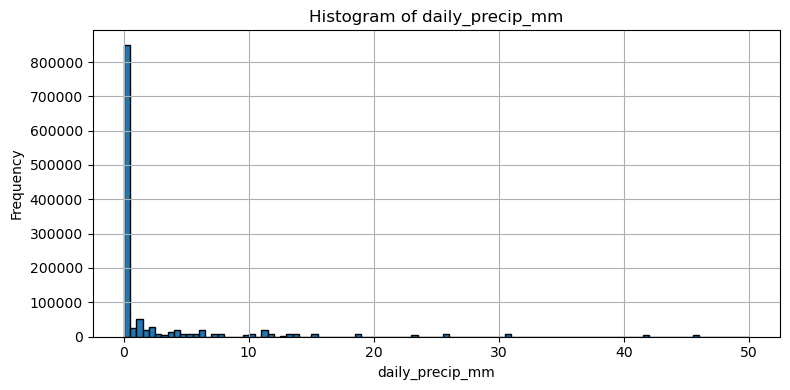

In [15]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 4))
taxi_weather['daily_precip_mm'].plot.hist(bins=100, edgecolor='black', range=(0, 50))
plt.xlabel("daily_precip_mm")
plt.title("Histogram of daily_precip_mm")
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
taxi_weather['daily_precip_mm'].describe(percentiles=[.25, .5, .75, .9, .95, .99])

count    1.166915e+06
mean     2.201188e+00
std      6.337019e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      7.620000e-01
90%      6.096000e+00
95%      1.270000e+01
99%      4.191000e+01
max      5.867400e+01
Name: daily_precip_mm, dtype: float64

In [17]:
bins = [0, 0.1, 2.5, 7.5, 15, 30, np.inf]
labels = ['none', 'light', 'moderate', 'heavy', 'very_heavy', 'extreme']
taxi_weather['daily_precip_class'] = pd.cut(
    taxi_weather['daily_precip_mm'], bins=bins, labels=labels, right=False
)

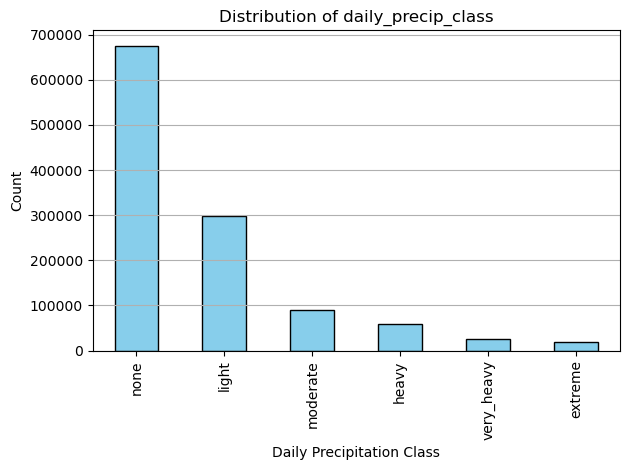

In [18]:
taxi_weather['daily_precip_class'].value_counts().sort_index().plot(
    kind='bar', edgecolor='black', color='skyblue'
)
plt.xlabel("Daily Precipitation Class")
plt.ylabel("Count")
plt.title("Distribution of daily_precip_class")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

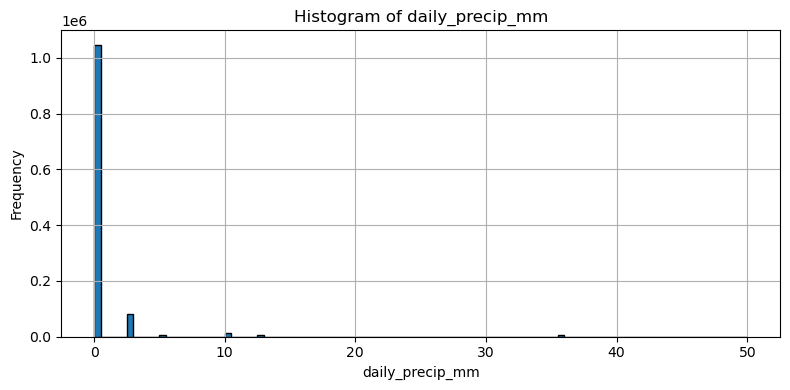

In [19]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 4))
taxi_weather['daily_snow_mm'].plot.hist(bins=100, edgecolor='black', range=(0, 50))
plt.xlabel("daily_precip_mm")
plt.title("Histogram of daily_precip_mm")
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
taxi_weather['daily_snow_mm'].describe(percentiles=[.25, .5, .75, .9, .95, .99])

count    1.166915e+06
mean     1.049369e+00
std      6.530281e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
90%      2.540000e+00
95%      2.540000e+00
99%      3.556000e+01
max      1.000000e+02
Name: daily_snow_mm, dtype: float64

In [21]:
bins = [0, 0.1, 5, np.inf]
labels = ['none', 'light', 'significant']
taxi_weather['daily_snow_class'] = pd.cut(
    taxi_weather['daily_snow_mm'], bins=bins, labels=labels, right=False
)


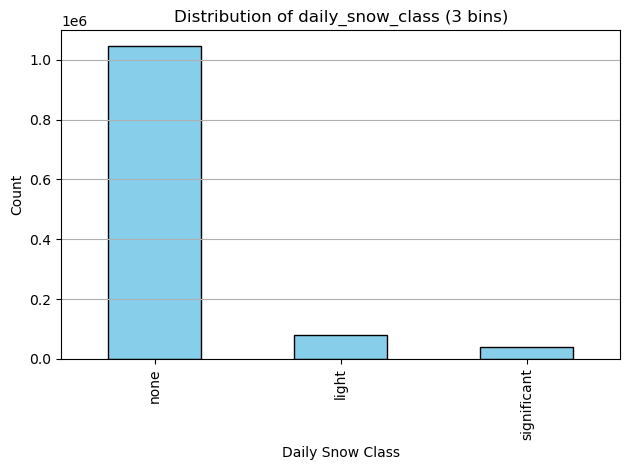

In [22]:
taxi_weather['daily_snow_class'].value_counts().sort_index().plot(
    kind='bar', edgecolor='black', color='skyblue'
)
plt.xlabel("Daily Snow Class")
plt.ylabel("Count")
plt.title("Distribution of daily_snow_class (3 bins)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Prepare

In [23]:
taxi_weather['pickup_datetime'] = pd.to_datetime(taxi_weather['pickup_datetime'])
taxi_weather['dropoff_datetime'] = pd.to_datetime(taxi_weather['dropoff_datetime'])
taxi_weather['datetime_hour'] = pd.to_datetime(taxi_weather['datetime_hour'])
taxi_weather['hav_dist_km_log'] = np.log1p(taxi_weather['hav_dist_km'])

In [24]:
num_cols = ['passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
            'dropoff_latitude', 'hav_dist_km_log', 'temp_c', 'windspeed_kph_sqrt',
            'humidity', 'pressure_hpa', 'daily_precip_mm', 'daily_snow_mm']

In [25]:
cat_cols = ['pickup_weekday', 'pickup_month', 'vendor_id', 'pickup_hour', 'hour_of_year',
            'hour_of_day', 'temp_code',
            'windspeed_code', 'humidity_code', 'fog_code', 'freezing_code', 'cloud_code',
            'hazy_code',
            'pressure_code', 'rain_code', 'snow_code', 'pickup_cluster', 'dropoff_cluster',
            'route_cluster', 'daily_precip_class', 'daily_snow_class']
for col in cat_cols:
  taxi_weather[col] = taxi_weather[col].astype('category')

In [26]:
bin_cols = ['store_and_fwd_flag_bin', 'fog', 'rain', 'snow', 'cloud_missing_flag']
taxi_weather[bin_cols] = taxi_weather[bin_cols].astype(bool)

In [27]:
cols_to_drop = [
  'id', 'pickup_datetime', 'dropoff_datetime', 'datetime_hour',
  'windspeed_outliers', 'daily_snow_outliers',
  'passenger_count_invalid', 'pickup_coord_invalid',
  'dropoff_coord_invalid', 'same_location_long_trip', 'trip_duration_outlier', 'windspeed_kph',
  'hav_dist_km', 'rain_mm', 'snow_mm'
]

# Pipeline transformer

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Preprocessing Pipelines
num_pipeline = Pipeline([("standardize", StandardScaler())])
cat_pipeline = Pipeline([("oneHotEncoding", OneHotEncoder(handle_unknown='ignore'))])
bool_pipeline = Pipeline([("identity", FunctionTransformer(validate=False))])

# Finaler ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols),
    ('bool', bool_pipeline, bin_cols)
])

# Modell-Pipeline
pipeline = Pipeline([
    ('pre', preprocessor),
    ('model', LinearRegression())
])

# Trainingsdaten vorbereiten
X_train = taxi_weather[num_cols + cat_cols + bin_cols]
y_train = taxi_weather_labels['trip_duration_log']

# Cross-Validation
scores = cross_val_score(pipeline, X_train, y_train,
                         scoring="neg_root_mean_squared_error", cv=5)
print("log-RMSE:", -scores.mean())